In [204]:
import librosa
import glob
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow

import scipy.stats as st
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, PredefinedSplit
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import joblib

In [6]:
zero_wavs = glob.glob('speechcommands/zero/*.wav')
one_wavs = glob.glob('speechcommands/one/*.wav')
two_wavs = glob.glob('speechcommands/two/*.wav')
three_wavs = glob.glob('speechcommands/three/*.wav')
four_wavs = glob.glob('speechcommands/four/*.wav')
five_wavs = glob.glob('speechcommands/five/*.wav')
six_wavs = glob.glob('speechcommands/six/*.wav')
seven_wavs = glob.glob('speechcommands/seven/*.wav')
eight_wavs = glob.glob('speechcommands/eight/*.wav')
nine_wavs = glob.glob('speechcommands/nine/*.wav')

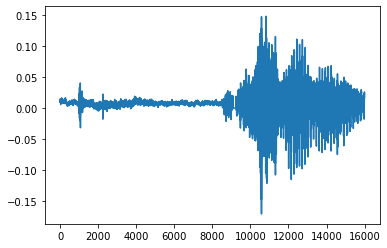

In [8]:
#Prueba para ver si están bien cargados los datos
x,sr = librosa.core.load(zero_wavs[2],sr=None)
plt.plot(x)
Audio(x,rate=sr)

In [9]:
zero_wavs[0:2]

['speechcommands/zero\\004ae714_nohash_0.wav',
 'speechcommands/zero\\004ae714_nohash_1.wav']

In [12]:
def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
    x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
    features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
    feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
    if energy:
        energy = librosa.feature.rms(x)
        features = np.concatenate([features,energy])
        feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
    summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
    feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
    if delta:
        deltafeatures = np.diff(features)
        summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
        d_names = ['d{}'.format(name) for name in feat_names]
    else:
        d_names = []

  #Y con los delta de segundo orden
    if deltadelta:
        deltadeltafeatures = np.diff(features,n=2)
        summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
        dd_names = ['dd{}'.format(name) for name in feat_names]
    else:
        dd_names = []

    feat_names = feat_names + d_names + dd_names
  
    return summary_features, feat_names  

In [16]:
df = pd.DataFrame()
wavs = [zero_wavs, one_wavs, two_wavs, three_wavs, four_wavs, five_wavs, 
        six_wavs, seven_wavs ,eight_wavs, nine_wavs ]

for wav in wavs:
    for i in range(len(wav)):
        feat, names = calculate_features(wav[i])
        df_aux = pd.DataFrame([feat], columns=names)
        name = wav[i]
        name = name[15:]
        df_aux['file'] = name
        target = name.split('/')[0]
        df_aux['target'] = target
        df = pd.concat([df, df_aux])
    display(df.head(2))
    df.to_csv('numbers.csv')
df

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,8.365962,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero\004ae714_nohash_0.wav
0,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,7.668771,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero\004ae714_nohash_1.wav
0,-341.238586,51.233425,-4.145040,34.477165,6.547458,20.492634,-15.897802,3.520656,-3.392641,9.468540,...,9.107476,6.306314,7.673291,6.406002,5.360076,6.473253,6.734374,0.002332,zero\012c8314_nohash_0.wav,zero\012c8314_nohash_0.wav
0,-360.989258,64.537750,9.405401,26.465500,-0.700320,13.971013,-13.274378,11.053991,-4.723043,9.374567,...,7.443700,7.157810,6.119327,8.040502,5.164283,4.487715,5.035290,0.003197,zero\012c8314_nohash_1.wav,zero\012c8314_nohash_1.wav
0,-392.943512,31.118288,-14.926441,14.474632,-0.212620,25.568863,-15.264872,1.459825,-15.500767,-13.244054,...,7.962722,7.361401,10.013330,11.303713,10.359199,8.653442,8.516176,0.011550,zero\0132a06d_nohash_0.wav,zero\0132a06d_nohash_0.wav
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-456.027832,109.481369,19.562944,19.511528,3.772255,6.759774,9.757759,-12.271667,-2.909657,0.060695,...,5.944093,8.881082,5.078656,7.303732,5.409833,6.233608,5.711779,0.005247,nine\ffd2ba2f_nohash_2.wav,nine\ffd2ba2f_nohash_2.wav
0,-466.599121,110.433922,15.317103,15.208471,6.003624,4.594473,12.463423,-9.313717,-4.941799,1.938881,...,8.026901,9.514495,8.412095,8.622720,8.206370,9.096728,7.875082,0.004873,nine\ffd2ba2f_nohash_3.wav,nine\ffd2ba2f_nohash_3.wav
0,-464.351471,118.847031,18.135073,18.381977,1.126530,3.008473,16.389320,-8.228055,-1.124835,-0.917100,...,9.023996,7.660374,6.290611,9.338147,6.103388,8.472475,5.100947,0.005135,nine\ffd2ba2f_nohash_4.wav,nine\ffd2ba2f_nohash_4.wav
0,-346.162048,110.403084,-16.399679,18.879353,2.637347,-4.486518,-20.273169,-15.073880,-17.549347,6.667893,...,9.319312,7.524152,9.900754,8.803493,5.853042,5.556843,7.432319,0.005080,nine\fffcabd1_nohash_0.wav,nine\fffcabd1_nohash_0.wav


In [30]:
df['target'] = df['target'].str.split('\\', expand=True)[0]

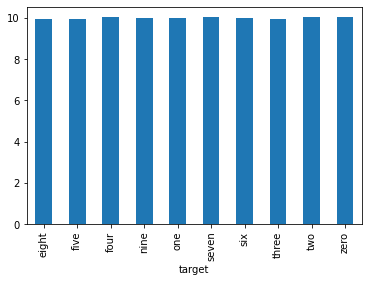

target
eight     9.94
five      9.96
four     10.02
nine      9.99
one      10.01
seven    10.04
six      10.01
three     9.96
two      10.03
zero     10.04
Name: mfcc_0_mean, dtype: float64

In [105]:
distribucion = round(df.groupby('target').count().iloc[:,0] / df['target'].count() * 100, 2)
distribucion.plot.bar()
plt.show()
distribucion

In [77]:
testing_list = pd.read_csv('speechcommands/testing_list.txt', sep=' ', 
                           names=['file_test'])
validation_list = pd.read_csv('speechcommands/validation_list.txt', sep=' ', 
                              names=['file_val'])

In [43]:
df['set'] = 'train'

In [83]:
testing_list['file_test'] = testing_list['file_test'].str.replace('/', '\\')
validation_list['file_val'] = validation_list['file_val'].str.replace('/', '\\')

In [68]:
df = df.merge(testing_list, left_on='file', right_on='file_test', how='left', suffixes=('', '_y'))
df['set'][df['file_test'].notna()] = 'test'
df.drop(columns='file_test', inplace=True)

In [84]:
df = df.merge(validation_list, left_on='file', right_on='file_val', how='left', suffixes=('', '_y'))
df['set'][df['file_val'].notna()] = 'validation'
df.drop(columns='file_val', inplace=True)

c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
df.head()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target,set
0,-392.156769,13.212129,-28.622875,53.432705,-24.832884,23.606667,-7.217955,2.866948,2.396463,16.450762,...,4.297504,5.047531,6.191907,7.406265,7.577165,5.521935,0.006879,zero\004ae714_nohash_0.wav,zero,train
1,-404.728485,9.000431,-25.368282,49.718231,-23.345776,24.290382,-5.570518,4.747909,1.976787,12.453028,...,5.911608,6.699411,7.094702,5.213796,4.898206,5.502960,0.005219,zero\004ae714_nohash_1.wav,zero,train
2,-341.238586,51.233425,-4.145040,34.477165,6.547458,20.492634,-15.897802,3.520656,-3.392641,9.468540,...,6.306314,7.673291,6.406002,5.360076,6.473253,6.734374,0.002332,zero\012c8314_nohash_0.wav,zero,train
3,-360.989258,64.537750,9.405401,26.465500,-0.700320,13.971013,-13.274378,11.053991,-4.723043,9.374567,...,7.157810,6.119327,8.040502,5.164283,4.487715,5.035290,0.003197,zero\012c8314_nohash_1.wav,zero,train
4,-392.943512,31.118288,-14.926441,14.474632,-0.212620,25.568863,-15.264872,1.459825,-15.500767,-13.244054,...,7.361401,10.013330,11.303713,10.359199,8.653442,8.516176,0.011550,zero\0132a06d_nohash_0.wav,zero,train


In [86]:
df.groupby('set').count()

,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,...,ddmfcc_5_std,ddmfcc_6_std,ddmfcc_7_std,ddmfcc_8_std,ddmfcc_9_std,ddmfcc_10_std,ddmfcc_11_std,ddenergy_std,file,target
set,,,,,,,,,,,,,,,,,,,,,
test,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552,...,2552,2552,2552,2552,2552,2552,2552,2552,2552,2552
train,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620,...,18620,18620,18620,18620,18620,18620,18620,18620,18620,18620
validation,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494,...,2494,2494,2494,2494,2494,2494,2494,2494,2494,2494


In [87]:
train = df[df['set']=='train']
validation = df[df['set']=='validation']
test = df[df['set']=='test']

#### Arrancandig the Naive Bayes

In [163]:
train = df[df['set']!='test']
test = df[df['set']=='test']

In [145]:
my_test_fold = np.where(train['set']=='validation', 0,-1)
ps = PredefinedSplit(test_fold=my_test_fold)

In [164]:
X_train = train.drop(columns=['set', 'file', 'target'])
y_train = train['target']
X_test = test.drop(columns=['set', 'file', 'target'])
y_test = test['target']

In [183]:
models = [GaussianNB(),
          RandomForestClassifier(class_weight='balanced'),
          GradientBoostingClassifier()]

In [184]:
params = [{},
          {'n_estimators': st.randint(50,200), 
           'max_features': st.randint(10,50), 
           'max_depth': st.randint(5,100), 
           'max_depth': st.randint(5,100)
          },
          {'n_estimators':range(20, 200, 5), 
           'max_depth':range(1,7), 
           'learning_rate':np.arange(0,1,0.001)
          }]

In [217]:
all_models = []
i = 0
for i in range(len(models)):
    rs = RandomizedSearchCV(models[i], params[i], n_iter = 30, scoring='accuracy', verbose= 1, n_jobs=-1, cv=ps, 
                            random_state=42)
    print (rs)
    fit = rs.fit(X_train, y_train)
    all_models.append(fit)

RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=GaussianNB(), n_iter=30, n_jobs=-1,
                   param_distributions={}, random_state=42, scoring='accuracy',
                   verbose=1)
Fitting 1 folds for each of 1 candidates, totalling 1 fits


c:\users\juan.miguel.ferraro\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 1 is smaller than n_iter=30. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    4.0s finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D19EB98C88>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D19EB8B948>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D19EB8B548>},
                   random_state=42, scoring='accuracy', verbose=1)
Fitting 1 folds for each of 30 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  8.3min finished


RandomizedSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                   estimator=GradientBoostingClassifier(), n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': array([0.   , 0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008,
       0.009, 0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017,
       0.018, 0.019, 0.02 , 0.021, 0.022, 0.023, 0.024, 0.025, 0.026,
       0.027, 0.028, 0.02...
       0.954, 0.955, 0.956, 0.957, 0.958, 0.959, 0.96 , 0.961, 0.962,
       0.963, 0.964, 0.965, 0.966, 0.967, 0.968, 0.969, 0.97 , 0.971,
       0.972, 0.973, 0.974, 0.975, 0.976, 0.977, 0.978, 0.979, 0.98 ,
       0.981, 0.982, 0.983, 0.984, 0.985, 0.986, 0.987, 0.988, 0.989,
       0.99 , 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998,
       0.999]),
                                        'max_depth': range(1, 7),
                                        'n_estimators': range(20, 200, 5)},
                   random_state=42, 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 76.8min finished


Mejor Modelo:  GaussianNB()
Val Accuracy:  0.5368885324779471
Test Accuracy:  0.5313479623824452


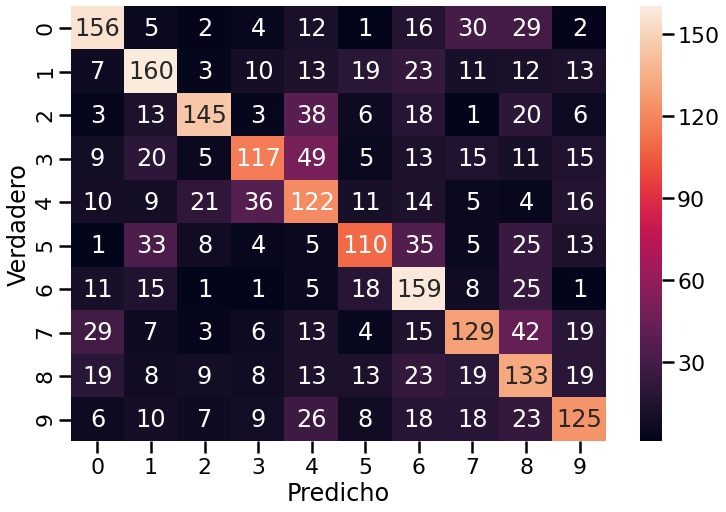

Clasification Report:
                precision    recall  f1-score   support

       eight       0.62      0.61      0.61       257
        five       0.57      0.59      0.58       271
        four       0.71      0.57      0.63       253
        nine       0.59      0.45      0.51       259
         one       0.41      0.49      0.45       248
       seven       0.56      0.46      0.51       239
         six       0.48      0.65      0.55       244
       three       0.54      0.48      0.51       267
         two       0.41      0.50      0.45       264
        zero       0.55      0.50      0.52       250

    accuracy                           0.53      2552
   macro avg       0.54      0.53      0.53      2552
weighted avg       0.54      0.53      0.53      2552

Mejor Modelo:  RandomForestClassifier(class_weight='balanced', max_depth=28, max_features=12,
                       n_estimators=199)
Val Accuracy:  0.6960705693664796
Test Accuracy:  0.6829937304075235


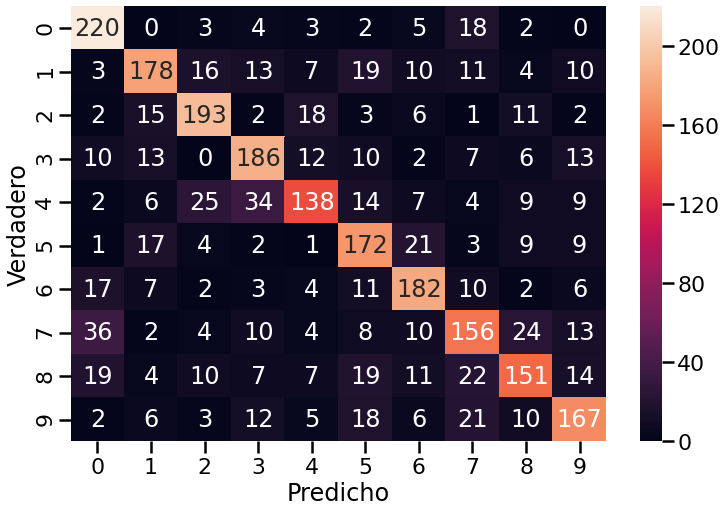

Clasification Report:
                precision    recall  f1-score   support

       eight       0.71      0.86      0.77       257
        five       0.72      0.66      0.69       271
        four       0.74      0.76      0.75       253
        nine       0.68      0.72      0.70       259
         one       0.69      0.56      0.62       248
       seven       0.62      0.72      0.67       239
         six       0.70      0.75      0.72       244
       three       0.62      0.58      0.60       267
         two       0.66      0.57      0.61       264
        zero       0.69      0.67      0.68       250

    accuracy                           0.68      2552
   macro avg       0.68      0.68      0.68      2552
weighted avg       0.68      0.68      0.68      2552

Mejor Modelo:  GradientBoostingClassifier(learning_rate=0.554, max_depth=6, n_estimators=195)
Val Accuracy:  0.7429831595829992
Test Accuracy:  0.7445141065830722


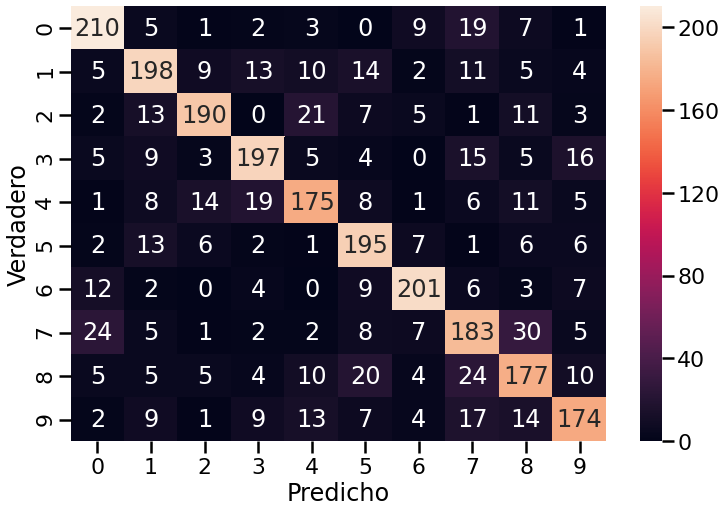

Clasification Report:
                precision    recall  f1-score   support

       eight       0.78      0.82      0.80       257
        five       0.74      0.73      0.74       271
        four       0.83      0.75      0.79       253
        nine       0.78      0.76      0.77       259
         one       0.73      0.71      0.72       248
       seven       0.72      0.82      0.76       239
         six       0.84      0.82      0.83       244
       three       0.65      0.69      0.67       267
         two       0.66      0.67      0.66       264
        zero       0.75      0.70      0.72       250

    accuracy                           0.74      2552
   macro avg       0.75      0.75      0.75      2552
weighted avg       0.75      0.74      0.74      2552



In [218]:
for i in all_models:
    print ("Mejor Modelo: ",i.best_estimator_)
    print ("Val Accuracy: ",i.best_score_)
    y_pred = i.predict(X_test)
    print ("Test Accuracy: ",accuracy_score(y_test, y_pred))
    plt.figure(figsize=(12,8))
    sns.set_context('poster')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='g')
    plt.xlabel('Predicho')
    plt.ylabel('Verdadero')
    plt.show()
    print ("Clasification Report:\n ",classification_report(y_test,y_pred))

In [219]:
# Guardamos los modelos por si las dudas
joblib.dump(all_models[0], './Modelos/GNB.sav')
joblib.dump(all_models[1], './Modelos/RF.sav')
joblib.dump(all_models[2], './Modelos/GB.sav')

['./Modelos/GB.sav']